
# Twitter Bot Detection — Baseline + BERT (KerasNLP) — Colab

Notebook completo para rodar no **Google Colab** com:
- Baseline: TF-IDF + Logistic Regression
- **Fine-tuning do BERT (KerasNLP)**

> Dica: Se o seu CSV já estiver no Drive, use a seção de montagem do Drive. Ou faça upload direto.


## 0. Ambiente (Colab)

In [1]:

# Se estiver no Colab, descomente para checar GPU:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[]

In [2]:

!pip install -U tensorflow tensorflow_text keras-nlp pandas scikit-learn


  Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)


## 1. Dados: carregar CSV

In [3]:

import os, pandas as pd, numpy as np
from pathlib import Path

DATA_PATH = Path('/content/bot_detection_data.csv')

assert DATA_PATH.exists(), f'CSV não encontrado em: {DATA_PATH}. Faça o upload ou monte o Drive.'
df = pd.read_csv(DATA_PATH, low_memory=False)
print('Shape:', df.shape)
df.head(3)


Shape: (50000, 11)


,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead


## 2. Colunas de texto e rótulo (com possibilidade de ajuste manual)

In [4]:

def infer_cols(df):
    label_priority = ["is_bot","bot","label","target","class","account_type","account_type_label","account_type_encoded"]
    text_priority = ["text","tweet","content","status","description","full_text"]
    label_col = None
    for p in label_priority:
        for c in df.columns:
            if str(c).lower()==p:
                label_col = c; break
        if label_col: break
    if not label_col:
        for c in df.columns:
            if df[c].nunique(dropna=True)==2:
                label_col = c; break
    text_cols = []
    for p in text_priority:
        for c in df.columns:
            if str(c).lower()==p:
                text_cols.append(c)
    if not text_cols:
        obj = [c for c in df.columns if df[c].dtype=='object']
        avg = sorted([(c, df[c].astype(str).str.len().mean()) for c in obj], key=lambda x: x[1], reverse=True)
        text_cols = [name for name,_ in avg[:2]]
    return text_cols, label_col

text_cols, label_col = infer_cols(df)

print('Inferido — texto:', text_cols)
print('Inferido — rótulo:', label_col)

# >>> Se precisar, defina manualmente aqui:
# text_cols = ['Tweet']        # exemplo
# label_col = 'is_bot'         # exemplo


Inferido — texto: ['Tweet']
Inferido — rótulo: Verified


In [5]:

# Preparação básica
def join_text(row, cols):
    return " ".join([str(row[c]) for c in cols if c in row and pd.notna(row[c])])

df["_text"] = df.apply(lambda r: join_text(r, text_cols), axis=1)

y = df[label_col]
if y.dtype=='object':
    mapping = {"bot":1,"bots":1,"human":0,"genuine":0,"nonbot":0,"non-bot":0,"real":0,"fake":1}
    y = y.astype(str).str.lower().map(lambda v: mapping.get(v, v))
y = pd.to_numeric(y, errors='coerce')

df = df[~y.isna() & (df["_text"].str.len()>0)].copy()
df["_label"] = y.astype(int)

print('Após limpeza:', df.shape)
df[["_text","_label"]].head(3)


Após limpeza: (50000, 13)


,_text,_label
0,Station activity person against natural majori...,0
1,Authority research natural life material staff...,1
2,Manage whose quickly especially foot none to g...,1


## 3. Split de treino/teste

In [6]:

from sklearn.model_selection import train_test_split

X = df["_text"].astype(str).values
y = df["_label"].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train:', len(X_train), 'Test:', len(X_test))


Train: 40000 Test: 10000


## 4. Baseline: TF-IDF + Logistic Regression

In [7]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=25000, ngram_range=(1,2), min_df=2, strip_accents="unicode")),
    ("clf", LogisticRegression(max_iter=150, solver="saga", n_jobs=1, class_weight="balanced"))
])
baseline.fit(X_train, y_train)


,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,'unicode'
,lowercase,True
,preprocessor,None
,tokenizer,None


[Baseline] AUC: 0.4940

[Baseline] Classification report:
               precision    recall  f1-score   support

           0     0.4938    0.4815    0.4876      4999
           1     0.4943    0.5067    0.5004      5001

    accuracy                         0.4941     10000
   macro avg     0.4941    0.4941    0.4940     10000
weighted avg     0.4941    0.4941    0.4940     10000



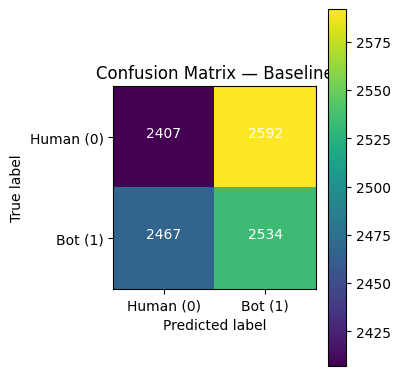

In [8]:

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np, matplotlib.pyplot as plt

y_pred_bl = baseline.predict(X_test)
proba_bl = baseline.predict_proba(X_test)[:,1]
auc_bl = roc_auc_score(y_test, proba_bl)

print(f"[Baseline] AUC: {auc_bl:.4f}")
print('\n[Baseline] Classification report:\n', classification_report(y_test, y_pred_bl, digits=4))

cm_bl = confusion_matrix(y_test, y_pred_bl)

plt.figure(figsize=(4,4))
plt.imshow(cm_bl, interpolation='nearest')
plt.title('Confusion Matrix — Baseline')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Human (0)', 'Bot (1)'])
plt.yticks(tick_marks, ['Human (0)', 'Bot (1)'])
thresh = cm_bl.max() / 2.
for i in range(cm_bl.shape[0]):
    for j in range(cm_bl.shape[1]):
        plt.text(j, i, format(cm_bl[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm_bl[i, j] > thresh else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


### 4.1 Salvar baseline

In [9]:

from pathlib import Path, PurePosixPath
import joblib, json

ARTIFACTS_DIR = Path('artifacts_bot_detection')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(baseline, ARTIFACTS_DIR / 'baseline_tfidf_logreg.joblib')
(ARTIFACTS_DIR / 'baseline_metrics.json').write_text(json.dumps({
    "auc": float(auc_bl),
    "label_col": label_col,
    "text_cols": text_cols,
    "n_rows_used": int(len(df))
}, indent=2))

print('Baseline salvo em:', ARTIFACTS_DIR)


Baseline salvo em: artifacts_bot_detection


## 5. Fine-tuning BERT (KerasNLP)

In [ ]:
# ===== BERT ultra-rápido (KerasNLP, Colab) =====
# Requisitos: X_train, y_train, X_test, y_test (texto cru e rótulos 0/1)

import os, gc, numpy as np, tensorflow as tf, keras_nlp
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# 0) Limpeza e otimizações
gc.collect()
tf.keras.backend.clear_session()
try:
    tf.config.optimizer.set_jit(True)  # XLA
except Exception:
    pass
try:
    from tensorflow.keras.mixed_precision import set_global_policy
    set_global_policy("mixed_float16")
except Exception:
    pass

# 1) Hiperparâmetros agressivos
PRESET    = "bert_base_en"    # presets válidos: "bert_base_en" ou "bert_large_en"
MAX_LEN   = 48                # bem curto para acelerar
BATCH     = 4                 # bem pequeno para caber na RAM
EPOCHS    = 1                 # 1 época (linear probing)
LR        = 5e-5              # um pouco maior p/ convergir mais rápido
MAX_PER_CLASS = 1500          # subamostragem estratificada agressiva
ARTIFACTS_DIR = "artifacts_bot_detection"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# 2) Subamostragem estratificada (rápida e leve)
def stratified_cap(X, y, max_per_class):
    X = np.asarray(X)
    y = np.asarray(y)
    sel_X, sel_y = [], []
    rng = np.random.RandomState(42)
    for cls in (0, 1):
        idx = np.where(y == cls)[0]
        if len(idx) > max_per_class:
            idx = rng.choice(idx, size=max_per_class, replace=False)
        sel_X.append(X[idx]); sel_y.append(y[idx])
    Xs = np.concatenate(sel_X); ys = np.concatenate(sel_y)
    order = rng.permutation(len(Xs))
    return Xs[order], ys[order]

X_train_fast, y_train_fast = stratified_cap(X_train, y_train, MAX_PER_CLASS)

# 3) tf.data minimalista (texto cru -> preprocessor embutido cuida do resto)
def to_ds(texts, labels, batch, shuffle):
    texts  = np.asarray(texts)
    labels = np.asarray(labels, dtype=np.int32)
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(8000, len(texts)), seed=42, reshuffle_each_iteration=True)
    return ds.batch(batch, drop_remainder=False).prefetch(1)

y_train_i32 = y_train_fast.astype(np.int32)
y_test_i32  = np.asarray(y_test, dtype=np.int32)

train_ds = to_ds(X_train_fast, y_train_i32, BATCH, True)
val_ds   = to_ds(X_test,       y_test_i32,  BATCH, False)

# 4) Modelo: preprocessor embutido + cabeça binária (sigmoid)
bert_clf = keras_nlp.models.BertClassifier.from_preset(
    PRESET,
    num_classes=1,            # saída 1D
    activation="sigmoid",     # prob da classe positiva
    sequence_length=MAX_LEN   # controla tokenização/padding interna
)

# Congela o backbone (linear probing)
bert_clf.backbone.trainable = False

bert_clf.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=LR),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
             tf.keras.metrics.AUC(name="auc")]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ARTIFACTS_DIR, "bert_best.keras"),
        monitor="val_auc", mode="max", save_best_only=True
    )
]

# 5) Treino super rápido (somente cabeça)
hist = bert_clf.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=1)


151/750 ━━━━━━━━━━━━━━━━━━━━ 3:00:53 18s/step - acc: 0.4915 - auc: 0.4904 - loss: 0.7007

### 5.1 Avaliação do BERT

In [ ]:

# Avaliação direta (métricas Keras)
eval_dict = bert_clf.evaluate(val_ds, return_dict=True)
eval_dict


In [ ]:

# Métricas detalhadas com sklearn (classification report, AUC, confusão)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

proba_bert = bert_clf.predict(val_ds)
# Saída é softmax -> coluna 1 é prob de classe "1"
p1 = proba_bert[:,1] if proba_bert.ndim==2 else proba_bert.squeeze()
y_pred_bert = (p1 >= 0.5).astype(int)

# Reconstruir y_test na mesma ordem: val_ds foi construído diretamente de X_test/y_test, então preserva a ordem
y_true = y_test

auc_bert = roc_auc_score(y_true, p1)
print(f"[BERT] AUC: {auc_bert:.4f}")
print('\n[BERT] Classification report:\n', classification_report(y_true, y_pred_bert, digits=4))

cm_bert = confusion_matrix(y_true, y_pred_bert)
cm_bert


In [ ]:

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(4,4))
plt.imshow(cm_bert, interpolation='nearest')
plt.title('Confusion Matrix — BERT')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Human (0)', 'Bot (1)'])
plt.yticks(tick_marks, ['Human (0)', 'Bot (1)'])
thresh = cm_bert.max() / 2.
for i in range(cm_bert.shape[0]):
    for j in range(cm_bert.shape[1]):
        plt.text(j, i, format(cm_bert[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm_bert[i, j] > thresh else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


### 5.2 Salvar modelo BERT e métricas

In [ ]:

import json

bert_final_path = ARTIFACTS_DIR / 'bert_final.keras'
bert_clf.save(bert_final_path)

bert_metrics_path = ARTIFACTS_DIR / 'bert_val_metrics.json'
with open(bert_metrics_path, 'w') as f:
    json.dump({"keras_eval": eval_dict, "auc": float(auc_bert)}, f, indent=2)

print('BERT salvo em:', bert_final_path)
print('Métricas em:', bert_metrics_path)



## 6. Notas
- Se a coluna inferida de rótulo não for **bot vs humano**, ajuste `label_col` manualmente na célula indicada.
- Para PT-BR ou multilíngue, considere presets multilingues (ex.: `bert_multi_cased` em libs alternativas) ou modelos do **Hugging Face Transformers**.
- A métrica **AUC** é recomendada para comparações; também avalie **F1** e **PR AUC** em datasets desbalanceados.
